Features:  ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']
Target:  HeartDisease
Acurácia do modelo:  0.9456521739130435


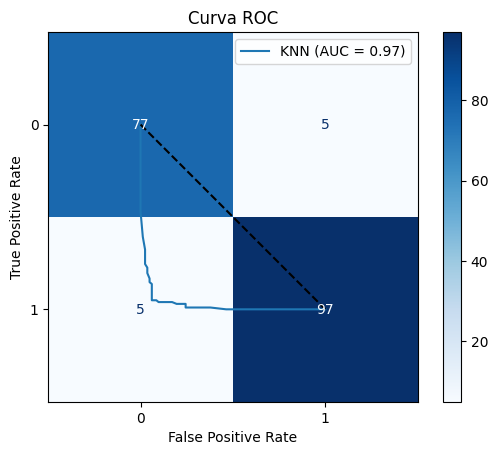

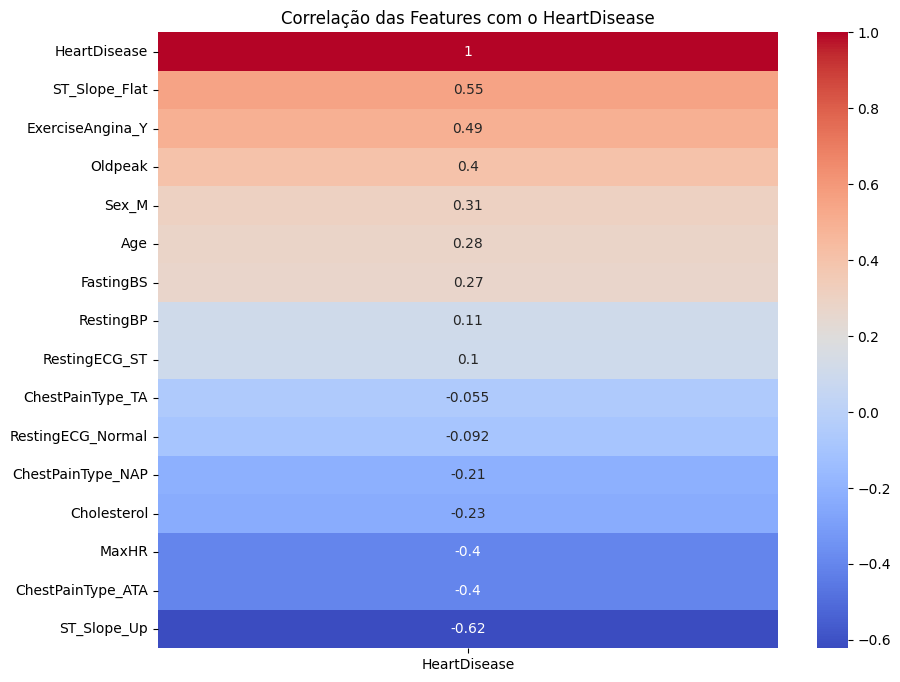

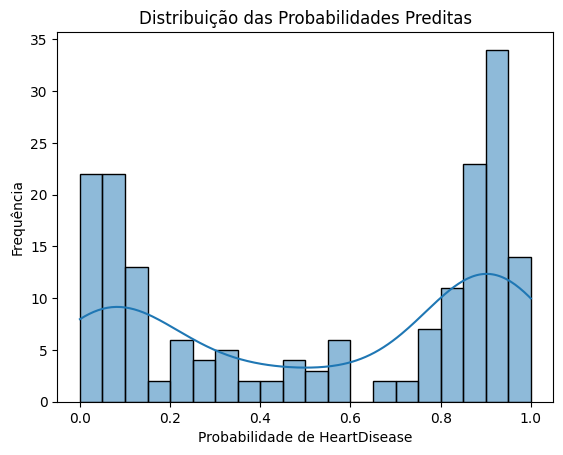

Total de erros: 10


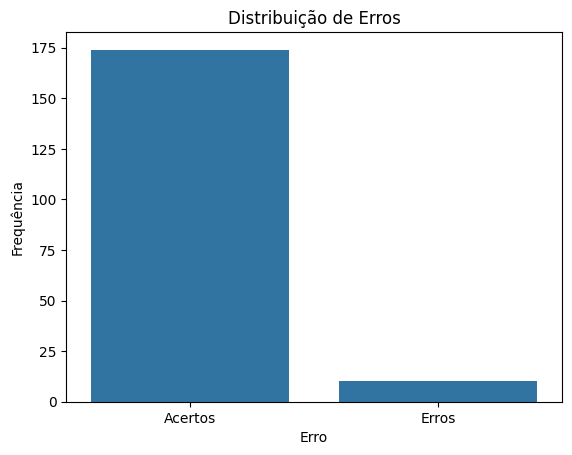

In [2]:
# Carregamento de Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

# Carregamento dos dados
df = pd.read_csv("heart.csv", encoding='utf-8')

# Visualizar as primeiras linhas do DF original
df.head(10)

# Identificar colunas categóricas
cat_cols = df.select_dtypes(include='object').columns

# Aplicar One-Hot Enconding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Visualizar primeiras linhas
df_encoded.head(10)

df_encoded.describe()

# Separa as features (variáveis independentes) do DataFrame codificado.
# Remove a coluna 'HeartDisease', que é a variável alvo (target), para ficar apenas com as variáveis preditoras.
X = df_encoded.drop('HeartDisease', axis=1)

# Seleciona a variável alvo (target), que é a coluna 'HeartDisease'
y = df_encoded['HeartDisease']

# Exibe a lista de nomes das colunas que compõem as features
print("Features: ", X.columns.to_list())

# Exibe o nome da coluna que está sendo usada como target
print("Target: ", y.name)

# Define a semente de aleatoriedade para garantir que a divisão dos dados seja reproduzível
# Em um outro notebook, achamos o melhor random_state que é o '132'
rs = 132

# Divide o conjunto de dados em treino (80%) e validação (20%)
# 'stratify=y' garante que a proporção das classes do target seja mantida nas duas divisões
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y)

# Cria um objeto para padronização, que transforma os dados para que tenham média 0 e desvio padrão 1
# scaler = StandardScaler()
scaler = StandardScaler()
# Ajusta o padronizador aos dados de treino e transforma esses dados
X_train_scaled = scaler.fit_transform(X_train)

# Transforma os dados de validação com o mesmo padronizador ajustado aos dados de treino
X_val_scaled = scaler.transform(X_val)

# Define o número de vizinhos (K) para o modelo KNN
# Em um outro notebook, achamos o melhor valor de K que é o '39'
k = 39

# Cria uma instância do classificador KNN com o valor de k definido
knn = KNeighborsClassifier(n_neighbors=k)

# Treina o modelo KNN utilizando os dados de treino padronizados
knn.fit(X_train_scaled, y_train)

# Realiza a previsão com o modelo treinado sobre os dados de validação padronizados
y_pred = knn.predict(X_val_scaled)

# Calcula a acurácia do modelo, ou seja, a proporção de acertos nas previsões
accuracy = accuracy_score(y_val, y_pred)

# Exibe a acurácia do modelo treinado
print("Acurácia do modelo: ", accuracy)

# Matriz de Confusão
# Para visualizar onde o modelo acerta e erra.
# Mostra a quantidade de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# Curva ROC e AUC
# Mostra a capacidade de discriminação do modelo.
# Ideal para problemas de classificação binária como o seu (HeartDisease: 0 ou 1).
# O AUC mede a área sob a curva → quanto mais próxima de 1, melhor.

# Probabilidades para a classe positiva
y_proba = knn.predict_proba(X_val_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_proba)
auc = roc_auc_score(y_val, y_proba)

plt.plot(fpr, tpr, label='KNN (AUC = {:.2f})'.format(auc))
plt.plot([0,1], [0,1], 'k--')  # Linha aleatória
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Importância das Features via coeficientes de correlação
# KNN não tem coeficientes diretamente, mas você pode usar análise exploratória:
# Correlação entre features e o target.
# Pode ajudar a ver quais variáveis mais influenciam.

# Se ainda não tiver dataframe completo:
df_encoded['HeartDisease'] = y  # Reanexa o target para análise

corr = df_encoded.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr[['HeartDisease']].sort_values(by='HeartDisease', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlação das Features com o HeartDisease')
plt.show()

# 4. Distribuição das probabilidades preditas
# Visualizar como o modelo está classificando as instâncias.
# Ideal para perceber se há muitos casos incertos (perto de 0.5).
sns.histplot(y_proba, bins=20, kde=True)
plt.title('Distribuição das Probabilidades Preditas')
plt.xlabel('Probabilidade de HeartDisease')
plt.ylabel('Frequência')
plt.show()

# Análise de erros: comparação entre y_val e y_pred
# Para ver onde o modelo errou.
# Pode usar gráfico de barras empilhadas.

errors = y_val != y_pred
print("Total de erros:", errors.sum())

sns.countplot(x=errors)
plt.title('Distribuição de Erros')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.xticks([0,1], ['Acertos', 'Erros'])
plt.show()